## Dynamic pressure (PPP) example

### Example data loading

In [1]:
from pathlib import Path
import pandas as pd

example_path = '/Users/knpob/Territory/Kolmo/data/footprint-to-pressure/pedar-walking/S41/S41 Lunalastic walking 1.asc'

df = pd.read_csv(
    Path(example_path),
    delimiter='\t', skiprows=9, index_col=0, header=0, 
    names=[idx + 1 for idx in range(199)]).loc[:, 1:198]
df

,1,2,3,4,5,6,7,8,9,10,...,189,190,191,192,193,194,195,196,197,198
0.02,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,127.5,157.5,30.0,0.0,0.0,0.0,65.0,27.5,20.0,0.0
0.04,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,127.5,160.0,35.0,0.0,0.0,0.0,67.5,27.5,20.0,0.0
0.06,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,127.5,162.5,35.0,0.0,0.0,0.0,67.5,27.5,20.0,0.0
0.08,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,127.5,165.0,35.0,0.0,0.0,0.0,67.5,27.5,20.0,0.0
0.10,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,127.5,165.0,35.0,0.0,0.0,0.0,72.5,27.5,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6.68,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,20.0,20.0,...,25.0,27.5,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0
6.70,0.0,0.0,0.0,0.0,0.0,0.0,25.0,20.0,20.0,20.0,...,35.0,32.5,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0
6.72,0.0,0.0,0.0,0.0,0.0,0.0,30.0,25.0,20.0,20.0,...,45.0,40.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0
6.74,0.0,0.0,0.0,0.0,0.0,20.0,30.0,25.0,25.0,20.0,...,47.5,47.5,0.0,0.0,0.0,0.0,25.0,0.0,20.0,0.0


### Gaussian filtering for smoothing

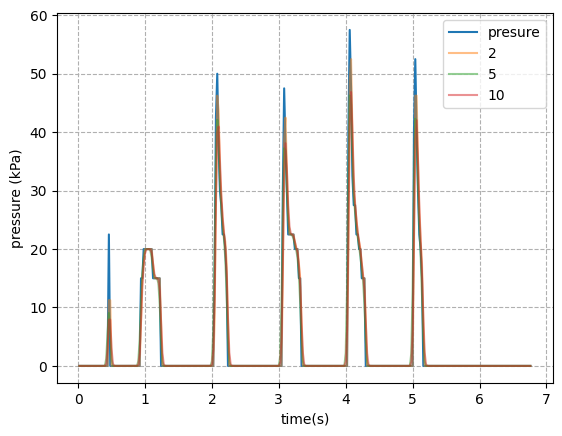

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def smooth(y, l=5, sig=1.0):
    pos = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    kernel = np.exp(-0.5 * np.square(pos) / np.square(sig))
    kernel /= np.sum(kernel)
    y_smooth = np.convolve(y, kernel, mode='same')
    return y_smooth

plt.plot(df[1].index, df[1].values, label='presure')
plt.plot(df[1].index, smooth(df[1].values, 2), label='2', alpha=0.5)
plt.plot(df[1].index, smooth(df[1].values, 5), label='5', alpha=0.5)
plt.plot(df[1].index, smooth(df[1].values, 10), label='10', alpha=0.5)

plt.xlabel('time(s)')
plt.ylabel('pressure (kPa)')
plt.grid(linestyle='--')
plt.legend()
plt.show()

### Peaks detection via diff

In [3]:
def sensor_ppp(series, only_return_ppp=True, **kwargs):
    """mean peak plantar pressure (PPP)"""
    smooth_values = smooth(series.values, **kwargs)
    diff = np.hstack([[0], smooth_values[1:] - smooth_values[:-1]])

    peak_ls = []
    peak_idx_ls = []
    peak_time_ls = []

    for idx, _ in enumerate(diff):
        if diff[idx] <= 0 and diff[idx-1] > 0:
            peak_idx_ls.append(idx - 1)
            peak_time_ls.append(series.index[idx - 1])
            peak_ls.append(series.values[idx - 1])
    
    if only_return_ppp:
        if len(peak_ls) == 0:
            # print('no peak pressure found')
            return 0
        else:
            return np.array(peak_ls).mean()
        
    else:
        if len(peak_ls) == 0:
            # print('no peak pressure found')
            return np.array([]), np.array([]), np.array([]), 0
        
        else:
            return np.array(peak_ls), np.array(peak_idx_ls), np.array(peak_time_ls), np.array(peak_ls).mean()

peak_ls, peak_idx_ls, peak_time_ls, ppp = sensor_ppp(df[1], only_return_ppp=False)

{
    'peak_ls': peak_ls, 
    'peak_idx_ls': peak_idx_ls, 
    'peak_time_ls': peak_time_ls,
    'mean peak pressure': ppp,
}

{'peak_ls': array([22.5, 20. , 50. , 47.5, 57.5, 52.5]),
 'peak_idx_ls': array([ 22,  50, 103, 153, 202, 251]),
 'peak_time_ls': array([0.46, 1.02, 2.08, 3.08, 4.06, 5.04]),
 'mean peak pressure': 41.666666666666664}

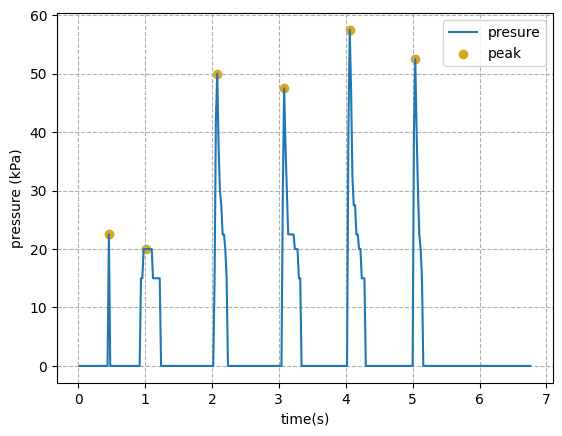

In [4]:
import matplotlib.pyplot as plt

plt.plot(df[1].index, df[1].values, label='presure')
plt.scatter(peak_time_ls, peak_ls, label='peak', color='goldenrod')

plt.xlabel('time(s)')
plt.ylabel('pressure (kPa)')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## Batch dynamic pressure (PPP) calculation

### Helper functions

In [5]:
def file_ppp(file_path, **kwargs):
    df = pd.read_csv(
        Path(file_path),
        delimiter='\t', skiprows=9, index_col=0, header=0, 
        names=[idx + 1 for idx in range(199)]).loc[:, 1:198]

    ppp_dict = {}

    for col in df.columns:
        ppp = sensor_ppp(df[col])
        ppp_dict[col] = ppp
        
    return ppp_dict

file_ppp(example_path)

{1: 41.666666666666664,
 2: 73.88888888888889,
 3: 81.875,
 4: 82.1875,
 5: 81.78571428571429,
 6: 54.44444444444444,
 7: 86.66666666666667,
 8: 124.75,
 9: 121.36363636363636,
 10: 150.83333333333334,
 11: 153.4375,
 12: 0,
 13: 62.5,
 14: 80.25,
 15: 108.18181818181819,
 16: 129.25,
 17: 143.88888888888889,
 18: 131.38888888888889,
 19: 115.0,
 20: 38.392857142857146,
 21: 40.208333333333336,
 22: 46.25,
 23: 58.888888888888886,
 24: 75.5,
 25: 81.66666666666667,
 26: 54.0625,
 27: 28.958333333333332,
 28: 33.46153846153846,
 29: 28.666666666666668,
 30: 21.666666666666668,
 31: 34.583333333333336,
 32: 57.0,
 33: 46.15384615384615,
 34: 36.041666666666664,
 35: 37.5,
 36: 37.166666666666664,
 37: 24.23076923076923,
 38: 21.53846153846154,
 39: 48.333333333333336,
 40: 55.45454545454545,
 41: 36.25,
 42: 31.153846153846153,
 43: 26.785714285714285,
 44: 25.384615384615383,
 45: 20.833333333333332,
 46: 28.5,
 47: 25.0,
 48: 36.0,
 49: 35.416666666666664,
 50: 28.125,
 51: 19.28571428

In [6]:
def extract_condition(file_path):
    for condition in ('BF', 'Lunalight', 'Lunalastic', 'PElite', 'Poron'):
        if condition in str(file_path):
            return condition
        
    print('no condition extracted: ', file_path)
    return None
        
extract_condition(example_path)

'Lunalastic'

In [7]:
import re

def extract_subject(file_path):
    match = re.search('S\d+', str(file_path))
    
    if match:
        return match.group()
    
    else:
        print('no subject extracted: ', file_path)
        return None
        
extract_subject(example_path)

'S41'

### PPP dataframe

In [8]:
from pathlib import Path
from tqdm.auto import tqdm
# from tqdm import tqdm

pedar_walking_folder = Path('/Users/knpob/Territory/Kolmo/data/footprint-to-pressure/pedar-walking')

data_ls = []

# for subject_folder in tqdm(list(pedar_walking_folder.iterdir())[:10]):
for subject_folder in tqdm(list(pedar_walking_folder.iterdir())):
    if subject_folder.is_dir():
        for file in subject_folder.iterdir():
            if file.suffix == '.asc':
                data_dict = file_ppp(file)
                data_dict['condition'] = extract_condition(file)
                data_dict['subject'] = extract_subject(file)
                data_ls.append(data_dict)

df_dynamic = pd.DataFrame(data_ls).groupby(['condition', 'subject']).mean()
df_dynamic

100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


1           2           3           4           5     
condition subject                                                              
BF        S1       23.611111   40.599327   48.240741   45.906339   40.758929  \
          S10      62.902778  131.601852  174.020655  123.630303  145.969697   
          S11      44.904684  133.418356  168.659188  148.419780  222.247289   
          S12      27.776292   80.177128  112.802198   61.685458   45.795455   
          S13      20.520833   55.452899  105.399798  101.331186  138.450980   
...                      ...         ...         ...         ...         ...   
Poron     S70      35.138889   48.279727   65.250000   45.677386   59.188596   
          S72      30.585317   48.790355   50.589496   41.772989   50.974747   
          S73      44.166667   80.972222   99.722222  123.079365  133.583333   
          S76      58.204545   89.039988   57.695250   49.727676   53.447250   
          S9       33.312500   64.623016   81.532738   51.727208   78.253968   

                         6           7           8           9           10    
condition subject                                                              
BF        S1       31.488095   84.000000  122.083333  125.416667  108.183712  \
          S10      18.166667   54.872379  138.293372  165.316964  182.030423   
          S11      22.083333   80.946947  134.489655  156.875534  135.593966   
          S12      24.722222   77.214547  116.599327   87.918803  102.910256   
          S13       0.000000   28.373016  110.546679  148.590686  129.973759   
...                      ...         ...         ...         ...         ...   
Poron     S70      89.317016  119.865741  138.969907  123.000000  107.701923   
          S72      29.557749   42.364988   89.768519   94.991687   78.037518   
          S73      53.571429   82.452652  110.273326  130.535714   70.026455   
          S76      38.979167   58.166059   79.208333  143.842593   81.583333   
          S9       59.951389   81.921296   98.426816  112.465278   57.454482   

                   ...         189        190        191        192   
condition subject  ...                                                
BF        S1       ...   56.205357  27.916667  21.554524  40.416667  \
          S10      ...   37.361111  17.166667  22.545011  25.722222   
          S11      ...   40.319201  39.697466  24.999094  29.488261   
          S12      ...   91.537037  33.161079  26.904762  43.769841   
          S13      ...  122.359788  25.009010  19.424211  24.136905   
...                ...         ...        ...        ...        ...   
Poron     S70      ...  105.410354  74.131653  50.843750  52.352694   
          S72      ...   58.433402  54.140212  55.638047  45.145503   
          S73      ...  199.988426  77.712302  35.749158  24.796296   
          S76      ...   83.805556  58.165266  33.884192  55.498316   
          S9       ...  141.687729  84.351852  66.447368  66.826876   

                         193        194         195        196        197   
condition subject                                                           
BF        S1       33.625000  24.583333   73.908730  78.708333  68.000000  \
          S10       7.000000   8.333333   10.166667  16.083333  37.142857   
          S11      24.411681   6.666667   10.833333   0.000000  31.309524   
          S12      25.707681   0.000000   21.203704  27.486111  39.296296   
          S13      21.701076  33.694444   67.222222  25.533696  34.915942   
...                      ...        ...         ...        ...        ...   
Poron     S70      47.129630  45.500000   76.033897  45.933862  64.833333   
          S72      28.450703  44.377104   28.680556  23.645623  30.666667   
          S73      32.391941  66.120370  121.337632  41.005141  71.666667   
          S76      51.176282  29.880952   70.861111  21.899325  35.699074   
          S9       60.493827  46.402882   80.751488  30.670635  30.507127   

                 

## Batch static pressure calculation

In [9]:
def file_avg(file_path, **kwargs):
    df = pd.read_csv(
        Path(file_path),
        delimiter='\t', skiprows=9, index_col=0, header=0, 
        names=[idx + 1 for idx in range(199)]).loc[:, 1:198]
    
    return df.mean().to_dict()

example_path = '/Users/knpob/Territory/Kolmo/data/footprint-to-pressure/pedar-standing/S1/S1 Lunalastic standing ground 1.asc'
file_avg(example_path)

{1: 2.1442558746736293,
 2: 0.8093994778067886,
 3: 2.976501305483029,
 4: 20.993798955613578,
 5: 2.108355091383812,
 6: 0.0,
 7: 34.184073107049606,
 8: 32.31396866840731,
 9: 40.18929503916449,
 10: 43.22127937336815,
 11: 33.25065274151436,
 12: 0.0,
 13: 0.0,
 14: 27.865535248041777,
 15: 46.282637075718014,
 16: 53.85117493472585,
 17: 44.41579634464752,
 18: 27.039817232375977,
 19: 38.177219321148826,
 20: 23.257180156657963,
 21: 48.425261096605745,
 22: 54.724216710182766,
 23: 51.19614882506527,
 24: 51.440926892950394,
 25: 50.985639686684074,
 26: 38.70593994778068,
 27: 24.929830287206265,
 28: 43.49053524804177,
 29: 47.21605744125326,
 30: 52.60117493472585,
 31: 55.106070496083554,
 32: 60.4242819843342,
 33: 39.90372062663185,
 34: 0.5091383812010444,
 35: 24.761749347258487,
 36: 26.422976501305484,
 37: 36.4686684073107,
 38: 46.17330287206266,
 39: 47.97976501305483,
 40: 50.052219321148826,
 41: 0.0,
 42: 0.0,
 43: 15.300261096605745,
 44: 0.1174934725848564,
 45:

In [10]:
pedar_standing_folder = Path('/Users/knpob/Territory/Kolmo/data/footprint-to-pressure/pedar-standing')

data_ls = []

# for subject_folder in tqdm(list(pedar_walking_folder.iterdir())[:10]):
for subject_folder in tqdm(list(pedar_walking_folder.iterdir())):
    if subject_folder.is_dir():
        for file in subject_folder.iterdir():
            if file.suffix == '.asc':
                data_dict = file_avg(file)
                data_dict['condition'] = extract_condition(file)
                data_dict['subject'] = extract_subject(file)
                data_ls.append(data_dict)

df_static = pd.DataFrame(data_ls).groupby(['condition', 'subject']).mean()
df_static

100%|██████████| 61/61 [00:09<00:00,  6.76it/s]


1          2          3          4          5     
condition subject                                                          
BF        S1        3.775465   5.775534   9.248151   9.390738   1.912485  \
          S10      11.702834  45.261010  50.163220  53.827341  44.513502   
          S11       6.764099  49.540212  75.388004  84.959511  68.562476   
          S12       5.674219  18.036976  27.094516  22.956029   4.653116   
          S13       4.739208  22.926890  43.658529  48.050588  50.106099   
...                      ...        ...        ...        ...        ...   
Poron     S70       9.707582  32.834391  46.090590  35.888137  47.750512   
          S72       1.737151  14.732487  23.336531  29.103168  10.724446   
          S73       3.004678  10.088178  13.280976  14.674520  12.892346   
          S76      16.192081  37.603321  27.203691  29.475671  26.728673   
          S9        2.202244   8.686974  13.269862  13.384167   9.317356   

                         6          7          8           9          10    
condition subject                                                           
BF        S1        4.184672  21.106885  28.323707   27.863962  23.377226  \
          S10       0.765894  38.468564  55.281089   58.067665  57.243330   
          S11       0.370349  26.340088  75.566686  100.914042  99.447464   
          S12       1.825154  45.801243  72.402075   80.017866  79.270867   
          S13       0.000000   4.289363  52.301395   70.362217  80.540009   
...                      ...        ...        ...         ...        ...   
Poron     S70      37.746280  50.717232  60.672761   56.779164  60.962782   
          S72       9.669019  32.375702  37.780810   37.168944  47.325572   
          S73       7.174968  35.809505  44.095205   28.055367  40.509111   
          S76      15.076759  37.372585  56.934346   46.533673  60.878861   
          S9       16.790443  31.875816  23.844913   26.115561  40.787593   

                   ...        189        190        191        192        193   
condition subject  ...                                                          
BF        S1       ...  12.370802   2.370889   5.507545   6.247668   3.839188  \
          S10      ...   8.657428   0.691377   9.086347   4.576237   0.600130   
          S11      ...   8.771654  11.715641   7.279425  10.234634   4.912023   
          S12      ...  20.672024  24.263052  14.507453  20.610585  21.292126   
          S13      ...  17.895887  12.568251   9.053223   1.812512  12.533170   
...                ...        ...        ...        ...        ...        ...   
Poron     S70      ...  44.065638  53.659102  24.386203  19.267364  33.267074   
          S72      ...  30.124719  25.367601  27.195512   7.343578  19.651295   
          S73      ...  48.591767  22.919834   8.573144   5.142008  22.018341   
          S76      ...  37.656406  26.473094  22.401365  14.881456  30.653198   
          S9       ...  32.709791  27.242121  42.293433  41.768507  40.917069   

                         194        195        196        197        198  
condition subject                                                         
BF        S1        1.381089  10.129169   9.756392  10.737820   7.091243  
          S10       0.190802   1.790607   2.687541   7.248119   0.556099  
          S11       0.099368   0.097109   0.000000   3.943493   0.000000  
          S12       0.000000   1.031822  12.636241  23.241433   1.941100  
          S13       1.951205   5.019309  21.287797  15.110662   0.897248  
...                      ...        ...        ...        ...        ...  
Poron     S70       5.136070  22.958936  19.936204   9.038669   0.908771  
          S72      10.314966   1.714185   4.787798   6.939606   0.000000  
          S73      20.555180  29.475298  25.525139  21.187380  18.088081  
          S76       2.036592   7.805216  12.375372   9.906066   0.018365  
          S9       14.073227  21.341827   6.751095  14.103810   0.000000  

[300

## Store processed data

In [11]:
df_dynamic.to_pickle('output/pedar_dynamic.pkl')
df_static.to_pickle('output/pedar_static.pkl')